In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import h5py

In [2]:
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
matplotlib.rcParams['font.size']=12

In [3]:
data_path = "/home/ryan/Data"

In [5]:
snap_path = data_path + '/run_CDM_710_HY/snap_127.hdf5'
fof_path = data_path + '/run_CDM_710_HY/fof_subhalo_tab_127.hdf5'
with h5py.File(fof_path, 'r') as s, h5py.File(snap_path, "r") as f:
    print(f['Header'].attrs['NumPart_Total'])
    for n in f['Header'].attrs['NumPart_Total']:
        print(np.cbrt(n))
    print(s['Subhalo/SubhaloMassType'].shape)
    print(len(s['Subhalo/SubhaloMassType']))
    print(len(s['Subhalo/SubhaloMassType'][:,0]))
    print(s['Subhalo/SubhaloSFR'])

[2313708  114400 2190078       0    4734      13]
132.26233412812297
48.54472085833889
129.8633277638242
0.0
16.79098155421193
2.3513346877207577
(174, 6)
174
174
<HDF5 dataset "SubhaloSFR": shape (174,), type "<f8">


In [6]:
snap_path = data_path + '/run_CDM_710_DM/snap_127.hdf5'
fof_path = data_path + '/run_CDM_710_DM/fof_subhalo_tab_127.hdf5'
with h5py.File(fof_path, 'r') as s, h5py.File(snap_path, "r") as f:
    print(f['Header'].attrs['NumPart_Total'])
    for n in f['Header'].attrs['NumPart_Total']:
        print(np.cbrt(n))
    print(s['Subhalo/SubhaloMassType'].shape)
    print(len(s['Subhalo/SubhaloMassType']))
    print(len(s['Subhalo/SubhaloMassType'][:,0]))
    print(s['Subhalo/SubhaloSFR'])

[      0  114400 2190078       0       0       0]
0.0
48.54472085833889
129.8633277638242
0.0
0.0
0.0
(151, 6)
151
151


KeyError: "Unable to synchronously open object (object 'SubhaloSFR' doesn't exist)"

In [ ]:
# TODO: plot main subhalo, find a good projection for gas
# need local density estimate, r_vir

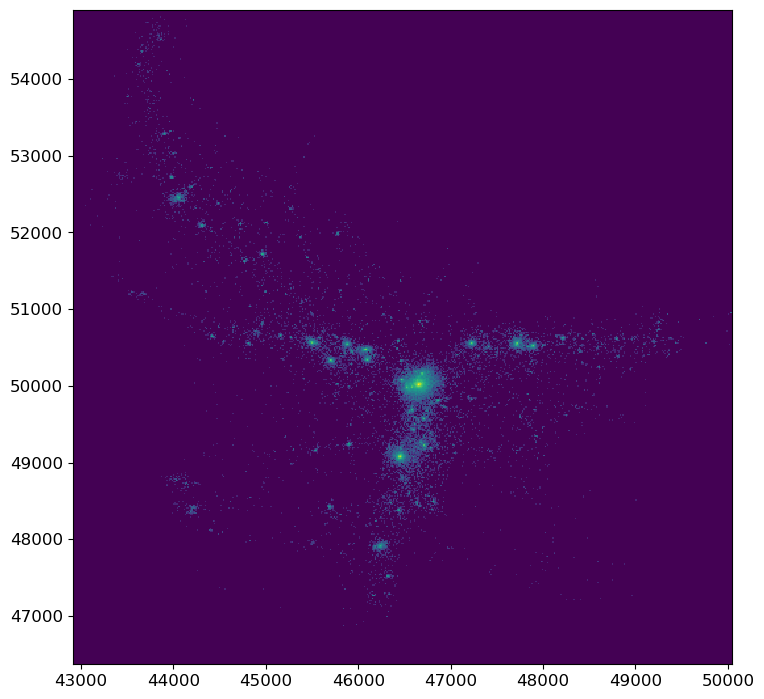

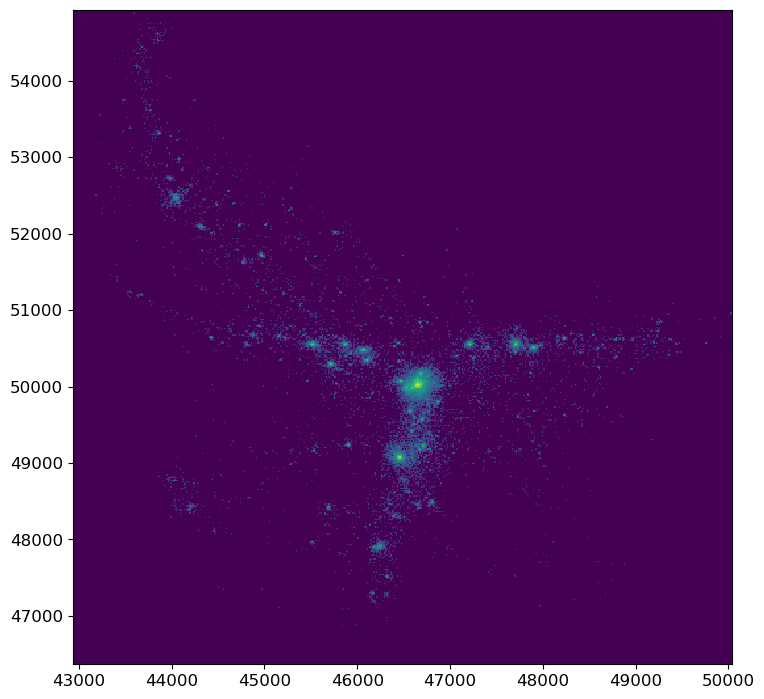

In [7]:
snap_path = data_path + '/run_CDM_710_HY/snap_127.hdf5'
fof_path = data_path + '/run_CDM_710_HY/fof_subhalo_tab_127.hdf5'
with h5py.File(fof_path, 'r') as s, h5py.File(snap_path, "r") as f:
    coords = f[f"PartType1/Coordinates"]
    average_z = np.mean(coords[:,2])
    std_z = np.std(coords[:,2])
    #masses = f[f"PartType1/Masses"][()]
    z_slice = (coords[:,2] < (average_z + std_z)) & (coords[:,2] > (average_z - std_z))

    x = coords[:,0][z_slice]
    y = coords[:,1][z_slice]
    #m = masses[z_slice]

#print(np.amax(x) - np.amin(x), np.amax(y) - np.amin(y))
Nbins=500
FIG_HEIGHT = 8.5
FIG_WIDTH = 8.5

FIGSIZE=[FIG_WIDTH,FIG_HEIGHT]
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
ax.hist2d(x, y, norm=LogNorm(clip=True), bins=Nbins)
plt.show()


snap_path = data_path + '/run_2cDM_710_HY_power00_sigma1/snap_127.hdf5'
fof_path = data_path + '/run_2cDM_710_HY_power00_sigma1/fof_subhalo_tab_127.hdf5'

with h5py.File(fof_path, 'r') as s, h5py.File(snap_path, "r") as f:
    coords = f[f"PartType1/Coordinates"]
    average_z = np.mean(coords[:,2])
    std_z = np.std(coords[:,2])
    #masses = f[f"PartType2/Masses"][()]
    z_slice = (coords[:,2] < (average_z + std_z)) & (coords[:,2] > (average_z - std_z))

    x = coords[:,0][z_slice]
    y = coords[:,1][z_slice]
    #m = masses[z_slice]

fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
ax.hist2d(x, y, norm=LogNorm(clip=True), bins=Nbins)
plt.show()

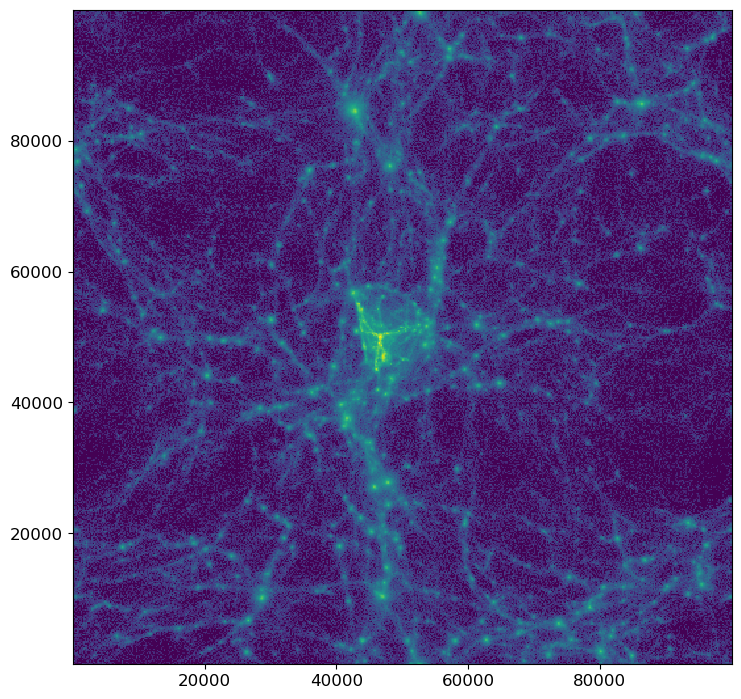

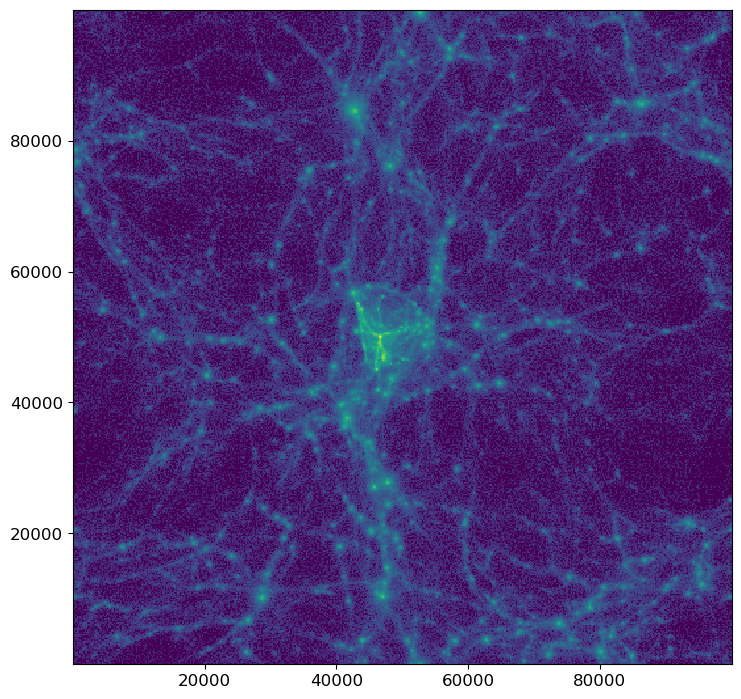

In [9]:
snap_path = data_path + '/run_CDM_710_HY/snap_127.hdf5'
fof_path = data_path + '/run_CDM_710_HY/fof_subhalo_tab_127.hdf5'
with h5py.File(fof_path, 'r') as s, h5py.File(snap_path, "r") as f:
    coords = f[f"PartType0/Coordinates"]
    average_z = np.mean(coords[:,2])
    std_z = np.std(coords[:,2])
    #masses = f[f"PartType1/Masses"][()]
    z_slice = (coords[:,2] < (average_z + std_z)) & (coords[:,2] > (average_z - std_z))

    x = coords[:,0][z_slice]
    y = coords[:,1][z_slice]
    #m = masses[z_slice]

#print(np.amax(x) - np.amin(x), np.amax(y) - np.amin(y))
Nbins=500
FIG_HEIGHT = 8.5
FIG_WIDTH = 8.5

FIGSIZE=[FIG_WIDTH,FIG_HEIGHT]
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
ax.hist2d(x, y, norm=LogNorm(clip=True), bins=Nbins)
plt.show()


snap_path = data_path + '/run_2cDM_710_HY_power00_sigma1/snap_127.hdf5'
fof_path = data_path + '/run_2cDM_710_HY_power00_sigma1/fof_subhalo_tab_127.hdf5'

with h5py.File(fof_path, 'r') as s, h5py.File(snap_path, "r") as f:
    coords = f[f"PartType0/Coordinates"]
    average_z = np.mean(coords[:,2])
    std_z = np.std(coords[:,2])
    #masses = f[f"PartType2/Masses"][()]
    z_slice = (coords[:,2] < (average_z + std_z)) & (coords[:,2] > (average_z - std_z))

    x = coords[:,0][z_slice]
    y = coords[:,1][z_slice]
    #m = masses[z_slice]

fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
ax.hist2d(x, y, norm=LogNorm(clip=True), bins=Nbins)
plt.show()